In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install pandasql 
from pandasql import sqldf
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

###############################################################################################
# Process Clinical data
###############################################################################################

patient_data = pd.read_csv('patient_data.csv')
patient = pd.read_csv('patient_data.csv')

patient = patient.set_index('track_name').T
patient = patient[1:]
patient = patient.reset_index()
patient = patient.rename(columns = {'index':'ID'})

patient['ID'] = patient['ID'].str.upper()
patient['Diagnosis Age'] = pd.to_numeric(patient['Diagnosis Age'])
patient['Overall Survival (Months)'] = pd.to_numeric(patient['Overall Survival (Months)'])
patient['Mutation Count'] = pd.to_numeric(patient['Mutation Count'])
patient['Sex'] = patient['Sex'].str.lower()
patient = patient[patient['# Samples per Patient']!='2'].reset_index(drop=True)

def label(x):
    if 'T1' in x:
        return 'T1'
    if 'T2' in x:
        return 'T2'
    if 'T3' in x:
        return 'T3'
    return 'T4'
patient['Stage'] = patient['American Joint Committee on Cancer Tumor Stage Code'].apply(lambda x: label(x))

patient = patient.drop(['Profiled in Mutations','Profiled in Putative copy-number alterations from GISTIC','Patient\'s Vital Status','# Samples per Patient','Cancer Type','Informed consent verified','Neoplasm Histologic Type Name'],axis=1)

###############################################################################################
# Process Tumor mRNA gene expression data
###############################################################################################

mrna_data = pd.read_csv('mrna_data.txt',sep='\t')
mrna = pd.read_csv('mrna_data.txt',sep='\t')

mrna.dropna(thresh=1,axis=1,inplace=True)
mrna = mrna.drop(['STUDY_ID'],axis=1)

def id_process(x):
    new = x[:len(x)-3]
    new = new.replace("_","")
    return new.upper()
mrna['SAMPLE_ID'] = mrna['SAMPLE_ID'].apply(lambda x: id_process(x))

###############################################################################################
# Process Tumor Mutation Sequencing data
###############################################################################################

seq_data = pd.read_csv('seq_data.txt',sep='\t')
seq = pd.read_csv('seq_data.txt',sep='\t')

seq.dropna(how='all',axis=1,inplace=True)
seq = seq.drop(['STUDY_ID'],axis=1)
seq['SAMPLE_ID'] = seq['SAMPLE_ID'].apply(lambda x: id_process(x))
seq = pd.get_dummies(seq, columns=seq.iloc[:,1:].columns,dummy_na=False)

###############################################################################################
# Process combined dataframe
###############################################################################################

def pysqldf(q):
    return sqldf(q, globals())

q = '''
SELECT *
FROM patient
JOIN mrna
ON patient.ID = mrna.SAMPLE_ID
JOIN seq
ON patient.ID = seq.SAMPLE_ID
'''
df = pysqldf(q)

df = df.drop(['SAMPLE_ID'],axis=1)

###############################################################################################
# Impute missing value

from sklearn.neighbors import KNeighborsClassifier

fitting = df
fitting = fitting.iloc[:,:90]
fitting = fitting.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Overall Survival Status','Sex','Stage'],axis=1)

race_fit = fitting.drop(['Neoplasm Histologic Grade'],axis=1)
null_index = race_fit.isnull().any(axis=1)
row_with_null = race_fit[null_index]
row_no_null = race_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Race Category'],axis=1)
y = row_no_null['Race Category']
clf.fit(x,y)
x_test = row_with_null.drop(['Race Category'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Race Category'] = imputes 

grade_fit = fitting.drop(['Race Category'],axis=1)
null_index = grade_fit.isnull().any(axis=1)
row_with_null = grade_fit[null_index]
row_no_null = grade_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Neoplasm Histologic Grade'],axis=1)
y = row_no_null['Neoplasm Histologic Grade']
clf.fit(x,y)
x_test = row_with_null.drop(['Neoplasm Histologic Grade'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Neoplasm Histologic Grade'] = imputes 




In [61]:
df

,ID,American Joint Committee on Cancer Tumor Stage Code,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,...,OR51B4_R124H,OR51B4_V247L,GALNT9_P147Lfs*25,KCNK3_G117D,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,CG-A3-3387,T1a,49,20.27,G2,WHITE,LIVING,male,70,T1,...,0,0,0,0,0,0,0,0,0,0
1,CG-A3-3374,T1b,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,...,0,0,0,0,0,0,0,0,0,0
2,CG-A3-3363,T2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,...,0,0,0,0,0,0,0,0,0,0
3,CG-CZ-5460,T3b,55,94.38,G2,WHITE,LIVING,male,52,T3,...,0,0,0,0,0,0,0,0,0,0
4,CG-BP-4176,T1b,64,64.22,G2,WHITE,LIVING,male,85,T1,...,0,0,0,0,0,0,0,0,0,0
5,CG-CJ-6032,T2,63,119.55,G3,WHITE,LIVING,female,42,T2,...,0,0,0,0,0,0,0,0,0,0
6,CG-BP-5192,T1a,59,23.46,G2,WHITE,LIVING,male,46,T1,...,0,0,0,0,0,0,0,0,0,0
7,CG-CW-5585,T3b,51,85.71,G2,WHITE,LIVING,male,41,T3,...,0,0,0,0,0,0,0,0,0,0
8,CG-B0-5691,T1a,66,112.71,G3,WHITE,LIVING,female,55,T1,...,0,0,0,0,0,0,0,0,0,0
9,CG-AK-3453,T2,58,83.15,G2,WHITE,LIVING,female,350,T2,...,0,0,0,0,0,0,0,0,0,0


In [120]:
df_temp = df
df_temp = df.drop(['ID','Stage'],axis=1)

In [121]:
df_temp_stage = df
df_temp_stage = df.drop(['ID','American Joint Committee on Cancer Tumor Stage Code'],axis=1)

In [122]:
x = df_temp.drop(['Overall Survival (Months)','Overall Survival Status'],axis=1)
x = pd.get_dummies(x, columns=['Sex','Race Category','Neoplasm Histologic Grade','American Joint Committee on Cancer Tumor Stage Code'])

In [175]:
x.iloc[:,:82]

,Diagnosis Age,Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,DGKK,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,-0.958603,0.063182,-0.194704,-0.360206,-0.312010,-0.507745,-0.311841,0.016756,-0.147743,-0.142661,...,-0.083584,-0.173809,-0.261508,0.203979,-0.769431,-0.347406,-0.330934,-0.204844,-0.140573,-0.046908
1,-0.793855,7.232136,-0.267978,1.218277,-0.312896,-0.687085,-0.234251,-0.574249,-0.112553,-0.237102,...,-0.024356,-0.208402,-0.261508,-0.700499,-0.768807,1.445127,-0.897537,-0.405603,-0.483525,-0.244104
2,-0.876229,11.032345,-0.215254,-0.311980,0.390556,10.039903,-0.413313,0.039219,17.387345,-0.237102,...,-0.083584,-0.071873,-0.261508,2.343723,-0.056431,-0.443870,-0.899530,0.633276,0.936498,-0.244104
3,-0.464360,-0.086171,-0.266423,-0.331488,-0.312896,-0.619540,-0.381806,-0.001339,-0.291168,-0.237102,...,-0.084010,-0.225698,-0.261508,0.326065,-0.759148,-0.398149,-0.443129,-0.405603,-0.115664,-0.244104
4,0.277005,0.187643,-0.278130,-0.336679,-0.309707,-0.612012,-0.407258,1.708656,-0.260243,-0.237102,...,-0.083691,-0.224675,-0.261508,1.622963,-0.489528,-0.251465,-0.692815,-0.405603,0.740434,-0.244104
5,0.194632,-0.169145,12.293202,-0.324874,2.489308,2.452115,-0.206556,0.530389,0.526516,-0.237102,...,-0.084010,-0.036666,-0.261508,2.031648,3.000066,-0.006644,2.227703,-0.405603,-0.483525,-0.244104
6,-0.134864,-0.135956,1.924847,0.911254,2.358678,-0.692069,-0.309598,-0.537747,-0.251819,-0.046877,...,-0.083904,-0.182099,2.334321,-0.698441,2.003217,0.074440,0.358173,-0.405603,-0.138007,-0.244104
7,-0.793855,-0.177443,4.689868,-0.345135,-0.278090,3.861397,-0.040836,0.377308,1.393252,0.172287,...,-0.084010,-0.219865,0.483353,-0.234298,-0.145647,-0.123300,-0.654868,5.512032,-0.186221,0.354337
8,0.441753,-0.061279,2.262810,-0.195852,0.154891,1.207828,-0.346823,0.581555,0.479916,-0.237102,...,-0.080921,0.460733,1.915998,-0.087912,0.100293,-0.233888,-0.724438,-0.066340,-0.483525,0.422339
9,-0.217238,2.386454,11.477770,-0.250525,-0.312896,-0.691561,0.445895,-0.276719,0.177817,21.796074,...,-0.076767,0.044084,0.179952,-0.702557,-0.749905,-0.395010,-0.911226,1.863890,-0.130951,13.335527


In [129]:
x_stage = df_temp_stage.drop(['Overall Survival (Months)','Overall Survival Status'],axis=1)
x_stage = pd.get_dummies(x_stage, columns=['Sex','Race Category','Neoplasm Histologic Grade','Stage'])

In [137]:
x_stage.iloc[:,:82]

,Diagnosis Age,Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,DGKK,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,49,70,-0.2189,-0.3900,-0.3361,-0.5138,-0.3317,-0.0256,-0.1675,-0.3360,...,-0.0830,-0.1707,-0.2581,0.2143,-0.7927,-0.3291,-0.2567,-0.1539,-0.1217,0.0041
1,51,934,-0.3084,1.4953,-0.3371,-0.6901,-0.2625,-0.5939,-0.1345,-0.6173,...,-0.0274,-0.2045,-0.2581,-0.7088,-0.7921,1.3842,-0.9107,-0.3519,-0.4425,-0.4822
2,50,1392,-0.2440,-0.3324,0.4572,9.8551,-0.4222,-0.0040,16.2764,-0.6173,...,-0.0830,-0.0711,-0.2581,2.3981,-0.1062,-0.4213,-0.9130,0.6727,0.8858,-0.4822
3,55,52,-0.3065,-0.3557,-0.3371,-0.6237,-0.3941,-0.0430,-0.3020,-0.6173,...,-0.0834,-0.2214,-0.2581,0.3389,-0.7828,-0.3776,-0.3862,-0.3519,-0.0984,-0.4822
4,64,85,-0.3208,-0.3619,-0.3335,-0.6163,-0.4168,1.6013,-0.2730,-0.6173,...,-0.0831,-0.2204,-0.2581,1.6625,-0.5232,-0.2374,-0.6744,-0.3519,0.7024,-0.4822
5,63,42,15.0343,-0.3478,2.8270,2.3959,-0.2378,0.4683,0.4648,-0.6173,...,-0.0834,-0.0367,-0.2581,2.0796,2.8367,-0.0034,2.6966,-0.3519,-0.4425,-0.4822
6,59,46,2.3700,1.1286,2.6795,-0.6950,-0.3297,-0.5588,-0.2651,-0.0507,...,-0.0833,-0.1788,2.1204,-0.7067,1.8769,0.0741,0.5387,-0.3519,-0.1193,-0.4822
7,51,41,5.7473,-0.3720,-0.2978,3.7813,-0.0900,0.3211,1.2776,0.6021,...,-0.0834,-0.2157,0.4244,-0.2330,-0.1921,-0.1149,-0.6306,5.4844,-0.1644,0.9936
8,66,55,2.7828,-0.1937,0.1911,1.1727,-0.3629,0.5175,0.4211,-0.6173,...,-0.0805,0.4493,1.7371,-0.0836,0.0447,-0.2206,-0.7109,-0.0173,-0.4425,1.1613
9,58,350,14.0383,-0.2590,-0.3371,-0.6945,0.3441,-0.3078,0.1378,65.0104,...,-0.0766,0.0422,0.1464,-0.7109,-0.7739,-0.3746,-0.9265,1.8864,-0.1127,33.0062


In [138]:
y = df_temp[['Overall Survival (Months)','Overall Survival Status']]
y.loc[:,['Overall Survival Status']] = np.where(y['Overall Survival Status'] == 'DECEASED',1,0)

In [139]:
survival_rate = y['Overall Survival Status'].sum()/y['Overall Survival Status'].shape[0]
survival_rate

0.32894736842105265

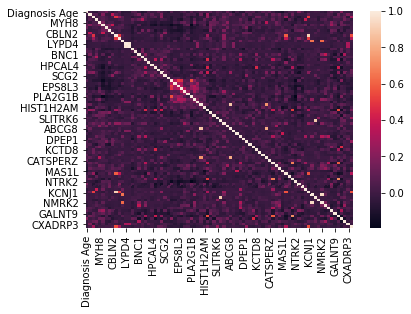

In [140]:
numeric_features = x.iloc[:,:82]
corr = numeric_features.corr()
sns.heatmap(corr)

In [141]:
###############################################################################################
# Train and select model
###############################################################################################


In [142]:
from sklearn import model_selection

# Reserve 20% for testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

print('training data has %d observation with %d features'% x_train.shape)
print('test data has %d observation with %d features'% x_test.shape)

training data has 425 observation with 208 features
test data has 107 observation with 208 features


In [143]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train.iloc[:,:82] = scaler.fit_transform(x_train.iloc[:,:82])
x_test.iloc[:,:82] = scaler.transform(x_test.iloc[:,:82])

In [144]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier(n_neighbors=3)

# Random Forest
classifier_RF = RandomForestClassifier()

# GB Regression
classifier_GB = GradientBoostingClassifier()

In [145]:
# Train the model by logistic regression
classifier_logistic.fit(x_train, y_train['Overall Survival Status'])
classifier_logistic.predict(x_test)
# Accuracy of test data
classifier_logistic.score(x_test, y_test['Overall Survival Status'])

0.719626168224299

In [73]:
# Train the model by kNN
classifier_KNN.fit(x_train, y_train['Overall Survival Status'])
classifier_KNN.predict(x_test)
# Accuracy of test data
classifier_KNN.score(x_test, y_test['Overall Survival Status'])

0.6542056074766355

In [74]:
# Train the model by random forest
classifier_RF.fit(x_train, y_train['Overall Survival Status'])
classifier_RF.predict(x_test)
# Accuracy of test data
classifier_RF.score(x_test, y_test['Overall Survival Status'])

0.7009345794392523

In [189]:
# Train the model by gradient boosting
classifier_GB.fit(x_train, y_train['Overall Survival Status'])
classifier_GB.predict(x_test)
# Accuracy of test data
classifier_GB.score(x_test, y_test['Overall Survival Status'])

0.6542056074766355

In [76]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest','Gradient Boosting']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_GB]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, x_train, y_train['Overall Survival Status'], cv=10)
    # cprint(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.720
Model accuracy of KNN is: 0.633
Model accuracy of Random Forest is: 0.706
Model accuracy of Gradient Boosting is: 0.703


In [77]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [78]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_LR.fit(x_train, y_train['Overall Survival Status'])

# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

# best LR model
best_LR_model = Grid_LR.best_estimator_

Best score: 0.729
Best parameters set:
	C: 0.1
	penalty: 'l1'


In [83]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [50,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,90,100],
    'min_samples_split': [3, 5, 10, 15, 20], 
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20, 30 ,50]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_RF.fit(x_train, y_train['Overall Survival Status'])

# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_

Best score: 0.758
Best parameters set:
	max_depth: 15
	max_features: 20
	min_samples_split: 15
	n_estimators: 64


In [80]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,50] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10, scoring='recall_weighted',n_jobs=-1)
Grid_KNN.fit(x_train, y_train['Overall Survival Status'])

# best k
print_grid_search_metrics(Grid_KNN)

# best KNN model
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.701
Best parameters set:
	n_neighbors: 7


In [92]:
# Possible hyperparamter options for Gradient Boosting Decision Tree
# Choose the number of trees
parameters = {
    'n_estimators' : (30,35,40,45,50,55,60,65,70,75,80),
    'learning_rate' : (0.05,0.1,0.15,0.2,0.3),
    'subsample' : (0.5,0.6,0.7,0.8,0.9,1),
    'max_depth': [3, 5, 10, 15, 20, 25],
    'max_features': [3, 5, 10, 20, 30, 50]
}
Grid_GB = GridSearchCV(GradientBoostingClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_GB.fit(x_train, y_train['Overall Survival Status'])

# best number of tress
print_grid_search_metrics(Grid_GB)

# best Gradient Boosting Decision Tree
best_GB_model = Grid_GB.best_estimator_

Best score: 0.767
Best parameters set:
	learning_rate: 0.3
	max_depth: 20
	max_features: 30
	n_estimators: 30
	subsample: 0.9


In [155]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['DEAD','LIVING']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [156]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test['Overall Survival Status'],best_LR_model.predict(x_test))),
    ("Random Forest", confusion_matrix(y_test['Overall Survival Status'],best_RF_model.predict(x_test))),
    ("Gradient Boosting", confusion_matrix(y_test['Overall Survival Status'],best_GB_model.predict(x_test)))
    
]

draw_confusion_matrices(confusion_matrices)

ValueError: X has 201 features per sample; expecting 208

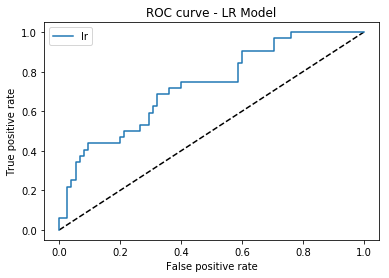

In [95]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test['Overall Survival Status'], y_pred_lr)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='lr')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [96]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.72875

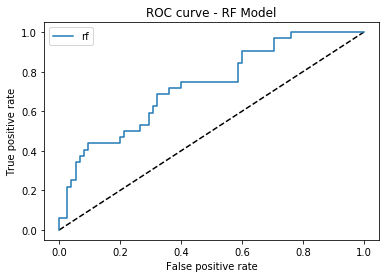

In [97]:
# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test['Overall Survival Status'], y_pred_rf)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='rf')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF Model')
plt.legend(loc='best')
plt.show()

In [98]:
# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.7687499999999999

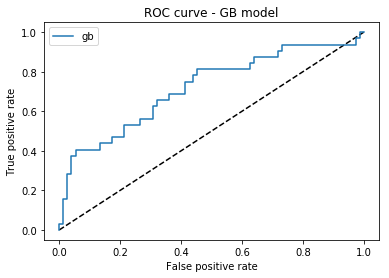

In [99]:
# Use predict_proba to get the probability results of Gradient Boosting model
y_pred_gb = best_GB_model.predict_proba(x_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test['Overall Survival Status'], y_pred_gb)

# ROC curve of Gradient Boosting result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='gb')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - GB model')
plt.legend(loc='best')
plt.show()

In [100]:
# AUC score
metrics.auc(fpr_gb,tpr_gb)

0.7179166666666668

(0, 1)

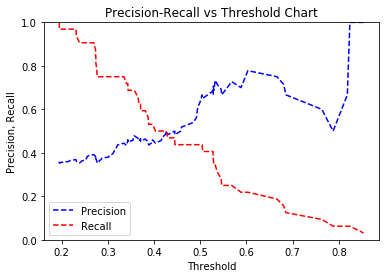

In [104]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_lr) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

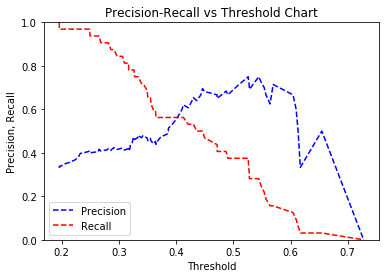

In [105]:
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_rf) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

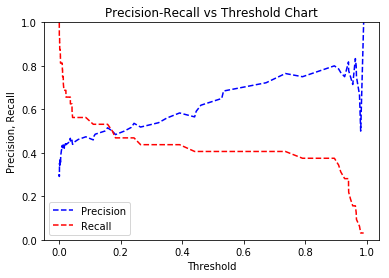

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_gb) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [102]:
def threshold_performance(classifier, threshold):
    cm = confusion_matrix(y_test['Overall Survival Status'],(classifier.predict_proba(x_test)[:,1] >= threshold).astype(int))
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Threshold is: %0.3f" % threshold)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

In [103]:
threshold_performance(best_GB_model, 0.2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=20,
              max_features=30, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.9, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Threshold is: 0.200
Accuracy is: 0.701
precision is: 0.500
recall is: 0.469


In [150]:
x_l1 = x
x_l1.iloc[:,:82] = scaler.fit_transform(x_l1.iloc[:,:82])
LRmodel_l1 = best_LR_model
LRmodel_l1.fit(x_l1, y['Overall Survival Status'])
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      x_l1.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
Neoplasm Histologic Grade_G4: 0.8293
Neoplasm Histologic Grade_G2: -0.5566
Diagnosis Age: 0.4156
American Joint Committee on Cancer Tumor Stage Code_T1b: -0.3802
American Joint Committee on Cancer Tumor Stage Code_T1a: -0.3039
SHISA6: -0.2663
DGKK: -0.2454
PCDHB1: -0.2221
HIST1H2AM: 0.2167
SLITRK6: 0.1988
NTRK2: -0.18
DPEP1: -0.1791
RLN1: -0.1604
CXADRP3: 0.1524
BEX1: 0.1475
STARD6: 0.1391
AVP: 0.1217
RIIAD1: -0.1023
XIST: 0.0962
SLC17A8: 0.0796
KCND2: 0.0778
MYMK: 0.0707
MYH8: -0.0695
EPHA7: 0.0656
CASR: -0.0644
SPON1: -0.0642
NXF2: 0.0631
BNC1: 0.0623
Mutation Count: -0.0572
SORCS1: -0.0566
S100A1: 0.0523
TMEM179: -0.0434
USH1G: -0.0431
CHRNA4: 0.043
FABP4: 0.0374
PCP4: -0.037
CATSPERZ: -0.03
LYPD4: -0.0299
SORCS3: 0.0297
KCTD8: 0.022
SCG2: 0.0199
CD5L: -0.0138
TRIM63: -0.011
UBE2QL1: -0.0061
DIPK1C: 0.002
ABCG8: 0.0
ABCG8_G432D: 0.0
ABCG8_P231L: 0.0
ABCG8_T76A: 0.0
American Joint Committee on Cancer Tumor Stage Code_T1: 0.0
American Joint Commit

In [151]:
# check feature importance of random forest for feature selection
x_feature_importance = x
forest = RandomForestClassifier()
forest.fit(x_feature_importance, y['Overall Survival Status'])

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), x_feature_importance.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
Neoplasm Histologic Grade_G4: 0.0382
SHISA6: 0.0324
FGF7: 0.0222
BEX1: 0.0217
LYPD4: 0.0214
EPS8L3: 0.0212
SLITRK5: 0.0188
TCEAL2: 0.0182
SERPINB2: 0.0181
UBE2QL1: 0.0178
KCND2: 0.0178
FBXL21P: 0.0174
Mutation Count: 0.0172
LRRTM3: 0.0166
EPHA7: 0.0165
DPEP1: 0.0165
TUBA4B: 0.0161
SORCS3: 0.0157
Diagnosis Age: 0.0157
ROS1: 0.0153
KCTD8: 0.0152
HIST1H2AM: 0.0149
USH1G: 0.0148
POF1B: 0.0147
CASR: 0.0141
GALNT9: 0.0137
FABP4: 0.0137
RGS7: 0.0133
NPB: 0.0133
NTRK2: 0.0132
FOXP2: 0.0128
SLITRK6: 0.0127
PLA2G1B: 0.0126
LCN10: 0.0126
CXADRP3: 0.0126
RORB: 0.012
MYH8: 0.0119
SPON1: 0.0117
DIPK1C: 0.0117
Neoplasm Histologic Grade_G2: 0.0116
KCNJ1: 0.0115
DEFB1: 0.0114
PPP1R14D: 0.0112
RLN1: 0.0109
HPCAL4: 0.0102
CAPSL: 0.0101
SLC6A17: 0.0099
KCNK3: 0.0094
ABCG8: 0.0091
CATSPERZ: 0.009
SCG2: 0.0088
American Joint Committee on Cancer Tumor Stage Code_T3a: 0.0087
PRSS12: 0.0083
SLC17A8: 0.0082
Neoplasm Histologic Grade_G3: 0.0082
PNMT: 0.0079
MAS1

In [146]:

# Reserve 20% for testing
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_stage, y, test_size=0.2)

print('training data has %d observation with %d features'% x_train.shape)
print('test data has %d observation with %d features'% x_test.shape)

# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train.iloc[:,:82] = scaler.fit_transform(x_train.iloc[:,:82])
x_test.iloc[:,:82] = scaler.transform(x_test.iloc[:,:82])

# Train the model by logistic regression
classifier_logistic.fit(x_train, y_train['Overall Survival Status'])
classifier_logistic.predict(x_test)
# Accuracy of test data
classifier_logistic.score(x_test, y_test['Overall Survival Status'])

# Train the model by kNN
classifier_KNN.fit(x_train, y_train['Overall Survival Status'])
classifier_KNN.predict(x_test)
# Accuracy of test data
classifier_KNN.score(x_test, y_test['Overall Survival Status'])

# Train the model by random forest
classifier_RF.fit(x_train, y_train['Overall Survival Status'])
classifier_RF.predict(x_test)
# Accuracy of test data
classifier_RF.score(x_test, y_test['Overall Survival Status'])

# Train the model by gradient boosting
classifier_GB.fit(x_train, y_train['Overall Survival Status'])
classifier_GB.predict(x_test)
# Accuracy of test data
classifier_GB.score(x_test, y_test['Overall Survival Status'])

# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest','Gradient Boosting']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_GB]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, x_train, y_train['Overall Survival Status'], cv=10)
    # cprint(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1


training data has 425 observation with 201 features
test data has 107 observation with 201 features
Model accuracy of Logistic Regression is: 0.705
Model accuracy of KNN is: 0.689
Model accuracy of Random Forest is: 0.715
Model accuracy of Gradient Boosting is: 0.719


In [169]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_LR.fit(x_train, y_train['Overall Survival Status'])

# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

# best LR model
best_LR_model = Grid_LR.best_estimator_



Best score: 0.739
Best parameters set:
	C: 0.15
	penalty: 'l1'


In [174]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [50,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,90,100],
    'min_samples_split': [3, 5, 10, 15, 20, 25], 
    'max_depth': [3, 5, 15, 25, 30],
    'max_features': [3, 5, 10, 20, 30, 40, 50]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_RF.fit(x_train, y_train['Overall Survival Status'])

# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_


Best score: 0.774
Best parameters set:
	max_depth: 25
	max_features: 50
	min_samples_split: 3
	n_estimators: 82


In [173]:

# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,50] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10, scoring='recall_weighted',n_jobs=-1)
Grid_KNN.fit(x_train, y_train['Overall Survival Status'])

# best k
print_grid_search_metrics(Grid_KNN)

# best KNN model
best_KNN_model = Grid_KNN.best_estimator_


Best score: 0.708
Best parameters set:
	n_neighbors: 4


In [152]:
# Possible hyperparamter options for Gradient Boosting Decision Tree
# Choose the number of trees
parameters = {
    'n_estimators' : (30,35,40,45,50,55,60,65,70,75,80),
    'learning_rate' : (0.05,0.1,0.15,0.2,0.3),
    'subsample' : (0.5,0.6,0.7,0.8,0.9,1),
    'max_depth': [3, 5, 10, 15, 20, 25],
    'max_features': [3, 5, 10, 20, 30, 50]
}
Grid_GB = GridSearchCV(GradientBoostingClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_GB.fit(x_train, y_train['Overall Survival Status'])

# best number of tress
print_grid_search_metrics(Grid_GB)

# best Gradient Boosting Decision Tree
best_GB_model = Grid_GB.best_estimator_


Best score: 0.781
Best parameters set:
	learning_rate: 0.1
	max_depth: 3
	max_features: 10
	n_estimators: 65
	subsample: 0.8


Logistic Regression
Accuracy is: 0.710
precision is: 0.586
recall is: 0.472


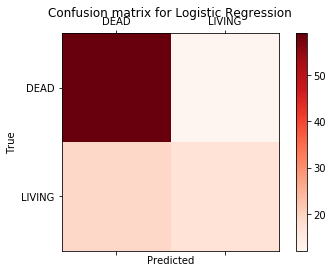

Random Forest
Accuracy is: 0.729
precision is: 0.652
recall is: 0.417


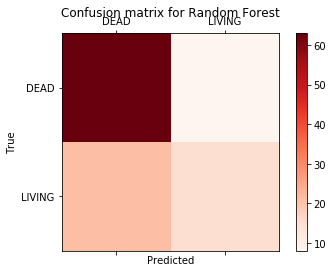

Gradient Boosting
Accuracy is: 0.682
precision is: 0.542
recall is: 0.361


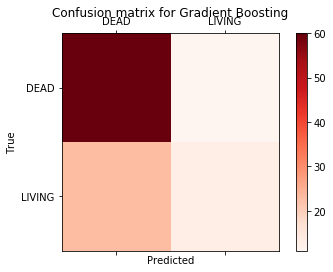

In [176]:

%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test['Overall Survival Status'],best_LR_model.predict(x_test))),
    ("Random Forest", confusion_matrix(y_test['Overall Survival Status'],best_RF_model.predict(x_test))),
    ("Gradient Boosting", confusion_matrix(y_test['Overall Survival Status'],best_GB_model.predict(x_test)))
    
]

draw_confusion_matrices(confusion_matrices)

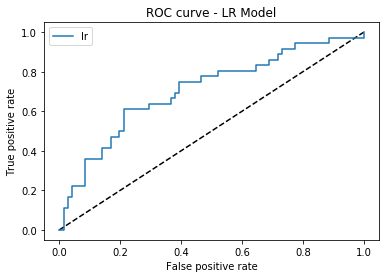

In [177]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test['Overall Survival Status'], y_pred_lr)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='lr')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

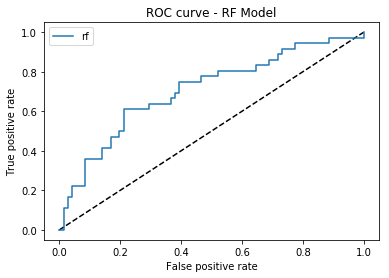

In [178]:
# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test['Overall Survival Status'], y_pred_rf)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='rf')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF Model')
plt.legend(loc='best')
plt.show()

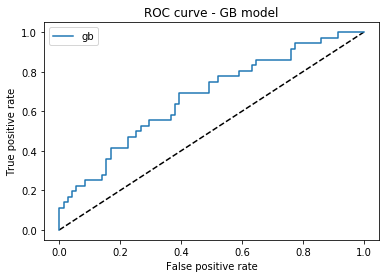

In [179]:
# Use predict_proba to get the probability results of Gradient Boosting model
y_pred_gb = best_GB_model.predict_proba(x_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test['Overall Survival Status'], y_pred_gb)

# ROC curve of Gradient Boosting result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='gb')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - GB model')
plt.legend(loc='best')
plt.show()

(0, 1)

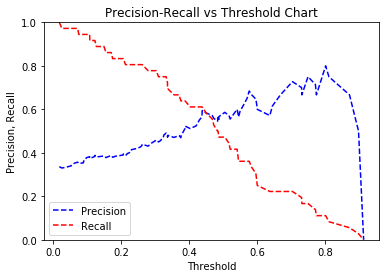

In [180]:
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_lr) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

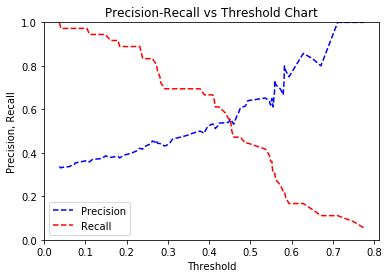

In [181]:
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_rf) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

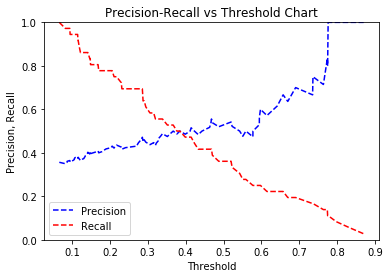

In [182]:
precision, recall, thresholds = precision_recall_curve(y_test['Overall Survival Status'], y_pred_gb) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [184]:
x_l1 = x_stage
x_l1.iloc[:,:82] = scaler.fit_transform(x_l1.iloc[:,:82])
LRmodel_l1 = best_LR_model
LRmodel_l1.fit(x_l1, y['Overall Survival Status'])
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      x_l1.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
Stage_T1: -0.7645
Neoplasm Histologic Grade_G4: 0.7196
Neoplasm Histologic Grade_G2: -0.4576
Diagnosis Age: 0.407
SHISA6: -0.2593
PCDHB1: -0.209
DGKK: -0.2048
SLITRK6: 0.2043
HIST1H2AM: 0.2017
RLN1: -0.1774
BEX1: 0.1646
NTRK2: -0.1611
DPEP1: -0.1589
CXADRP3: 0.1525
STARD6: 0.1499
RIIAD1: -0.1058
XIST: 0.093
AVP: 0.0929
KCND2: 0.0703
BNC1: 0.0696
MYMK: 0.0683
S100A1: 0.0668
SLC17A8: 0.0621
MYH8: -0.0607
CASR: -0.0606
TMEM179: -0.0542
EPHA7: 0.0475
SORCS1: -0.043
LYPD4: -0.0427
CATSPERZ: -0.0405
PCP4: -0.0397
Mutation Count: -0.0387
NXF2: 0.0387
FABP4: 0.0365
SPON1: -0.0339
CHRNA4: 0.0271
SCG2: 0.0252
KCTD8: 0.0216
SORCS3: 0.0211
CD5L: -0.0122
USH1G: -0.0118
NPB: 0.0095
DEFA4: -0.0024
ABCG8: 0.0
ABCG8_G432D: 0.0
ABCG8_P231L: 0.0
ABCG8_T76A: 0.0
BNC1_R114Q: 0.0
BNC1_V960E: 0.0
BNC1_Y264H: 0.0
C16ORF78: 0.0
C16ORF78_D99G: 0.0
C16ORF78_R40Q: 0.0
CAPSL: 0.0
CAPSL_P25R: 0.0
CASR_F788Y: 0.0
CASR_G325R: 0.0
CASR_L37Afs*11: 0.0
CASR_T712I: 0.0
CASR_V104I: 0.

In [185]:
# check feature importance of random forest for feature selection
x_feature_importance = x_stage
forest = RandomForestClassifier()
forest.fit(x_feature_importance, y['Overall Survival Status'])

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), x_feature_importance.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
Diagnosis Age: 0.0353
HIST1H2AM: 0.0283
BEX1: 0.0256
Stage_T1: 0.0243
UBE2QL1: 0.0238
LYPD4: 0.0238
Neoplasm Histologic Grade_G4: 0.0229
BNC1: 0.0212
LCN10: 0.0194
XIST: 0.0188
CD5L: 0.0188
NPB: 0.0182
SORCS3: 0.0175
USH1G: 0.0174
TCEAL2: 0.0164
FGF7: 0.0158
Stage_T3: 0.0155
RORB: 0.0154
POF1B: 0.0152
DEFB1: 0.0144
ABCG8: 0.0144
SLC6A17: 0.0141
RGS7: 0.0141
DPEP1: 0.0141
GALNT9: 0.0136
NTRK2: 0.0134
F12: 0.0131
PLA2G1B: 0.0129
KCND2: 0.0129
AVP: 0.0129
SCG2: 0.0128
CASR: 0.0121
FBXL21P: 0.0119
TUBA4B: 0.0116
KCNK3: 0.0116
PRSS12: 0.0113
CBLN2: 0.011
SORCS1: 0.0109
SLITRK5: 0.0108
SPON1: 0.0107
DIPK1C: 0.0105
Mutation Count: 0.0103
FABP4: 0.0102
SHISA6: 0.0101
MYH8: 0.01
SCRT1: 0.0099
S100A1: 0.0097
LRRTM3: 0.0097
CXADRP3: 0.0097
SLITRK6: 0.0096
CAPSL: 0.0093
PNMT: 0.0092
PLPPR5: 0.0092
KCNJ1: 0.0092
PCP4: 0.0089
PPP1R14D: 0.0085
HPCAL4: 0.0084
RLN1: 0.0082
MAS1L: 0.008
FOXP2: 0.0079
Stage_T4: 0.0078
TRIM63: 0.0076
TMEM179: 0.0076
GAL3S